Original lab created by [Amaia Salvador](https://imatge.upc.edu/web/people/amaia-salvador) for [Persontyle](https://persontyle.com/) (2016).

Adapted by [Janna Escur](https://www.linkedin.com/in/janna-escur-i-gelabert-276b1212b/) for the [Postgraduate Course on Artificial Intelligence with Deep Learning](https://github.com/upcschool-ai/2019-spring) at [UPC School](https://www.talent.upc.edu/cat/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) (2019)

# Object Detection I: Training

In this session we will train an SSD model using Pascal VOC data. SSD was introduced in the paper:

Liu et al. [SSD: Single Shot MultiBox Detector](https://arxiv.org/pdf/1512.02325.pdf). ECCV 2016


SSD is an unified framework for object detection with a single network. The original implementation in Caffe can be found [here](https://github.com/weiliu89/caffe/tree/ssd). In this example we will use [an implementation](https://github.com/rykov8/ssd_keras) in keras and tensorflow.

NOTE: To understand the whole structure and the functioning of this model you would need much more than an hour and a half. Do not panic at all if you find some concepts hard to understand! Every model (and every implementation!!!!) has its own particularities. The important thing is to get the idea of how an object detector work.

<img src="https://github.com/telecombcn-dl/2017-persontyle/blob/master/sessions/detection/figs/ssd_overview.PNG?raw=1">

IMPORTANT!!!!
We need to install an old version of tensorflow because it is a notebook from a (quite) old repository. With this old version, we will not be able to run the code in Tensorflow using GPU (even Colab environment is set to GPU), due to CUDA incompatibilities. That is why we will not be able to train the model (it would take sooooooo long). Instead, we will load the weights, as you will see at the end of the lab.

Also, after executing the next cell, we need to restart the runtime, an option will apear so you only have to click there;) All the variables will be lost, but... we have just started so we are not losing anything!

In [0]:
!pip install q keras==1.2.2 tensorflow==0.12

In [0]:
import tensorflow as tf
print tf.__version__

0.12.0


Let's clone the repository where this notebook is located:

In [0]:
!git clone https://github.com/telecombcn-dl/2017-persontyle.git

Cloning into '2017-persontyle'...
remote: Enumerating objects: 294, done.
remote: Total 294 (delta 0), reused 0 (delta 0), pack-reused 294
Receiving objects: 100% (294/294), 45.07 MiB | 35.02 MiB/s, done.
Resolving deltas: 100% (113/113), done.


I suggest to open it (https://github.com/telecombcn-dl/2017-persontyle/tree/master/sessions/detection/ssd_keras) if you want to look at the classes we are importing. This may help you to understand how it really works.

We have cloned the repository and we need to access to the directory where the code is located, so all the imports in this notebook will work

In [0]:
cd 2017-persontyle/sessions/detection/ssd_keras

/content/2017-persontyle/sessions/detection/ssd_keras/2017-persontyle/sessions/detection/ssd_keras/2017-persontyle/sessions/detection/ssd_keras


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

In [0]:
import numpy as np
import pickle
from ssd import SSD300
from ssd_utils import BBoxUtility, Generator

SEED = 4242
np.random.seed(SEED)

Load the prior bounding boxes and initialize the bounding box utilities:

In [0]:
NUM_CLASSES = 21
input_shape = (300, 300, 3)
nms_thresh = 0.4
priors = pickle.load(open('../data/files/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors, nms_thresh = nms_thresh)

Let's look at the prior boxes:

In [0]:
print(np.shape(priors))
print (priors[0])

(7308, 8)
[0.         0.         0.06315789 0.06315789 0.1        0.1
 0.2        0.2       ]


priors[i] = [xmin, ymin, xmax, ymax, varxc, varyc, varw, varh]

Download the Pascal VOC data which contains the images and the annotations:

In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

--2019-03-21 17:44:19--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar.1’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  12.7MB/s    in 35s     

2019-03-21 17:44:54 (12.5 MB/s) - ‘VOCtrainval_06-Nov-2007.tar.1’ saved [460032000/460032000]



In [0]:
!tar -xvf VOCtrainval_06-Nov-2007.tar

VOCdevkit/
VOCdevkit/VOC2007/
VOCdevkit/VOC2007/Annotations/
VOCdevkit/VOC2007/Annotations/000005.xml
VOCdevkit/VOC2007/Annotations/000007.xml
VOCdevkit/VOC2007/Annotations/000009.xml
VOCdevkit/VOC2007/Annotations/000012.xml
VOCdevkit/VOC2007/Annotations/000016.xml
VOCdevkit/VOC2007/Annotations/000017.xml
VOCdevkit/VOC2007/Annotations/000019.xml
VOCdevkit/VOC2007/Annotations/000020.xml
VOCdevkit/VOC2007/Annotations/000021.xml
VOCdevkit/VOC2007/Annotations/000023.xml
VOCdevkit/VOC2007/Annotations/000024.xml
VOCdevkit/VOC2007/Annotations/000026.xml
VOCdevkit/VOC2007/Annotations/000030.xml
VOCdevkit/VOC2007/Annotations/000032.xml
VOCdevkit/VOC2007/Annotations/000033.xml
VOCdevkit/VOC2007/Annotations/000034.xml
VOCdevkit/VOC2007/Annotations/000035.xml
VOCdevkit/VOC2007/Annotations/000036.xml
VOCdevkit/VOC2007/Annotations/000039.xml
VOCdevkit/VOC2007/Annotations/000041.xml
VOCdevkit/VOC2007/Annotations/000042.xml
VOCdevkit/VOC2007/Annotations/000044.xml
VOCdevkit/VOC2007/Annotations/000046.

Create training file based on PASCAL VOC data. This will put all the information (i.e. box coordinates, categories and image paths) into a single file:

In [0]:
import os
from PASCAL_VOC.get_data_from_XML import XML_preprocessor
data = XML_preprocessor('VOCdevkit/VOC2007/Annotations/').data
pickle.dump(data,open('../data/files/VOC2007.pkl','wb'))

We load the annotations file:

In [0]:
gt = pickle.load(open('../data/files/VOC2007.pkl', 'rb'))

Let's take a peek at this file:

In [0]:
key1 = gt.keys()[0]
print (key1)
print (gt[key1][0])

007777.jpg
[0.004      0.52406417 0.74       1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


The first 4 positions are the coordinates of the bounding box, and the remaining ones compose the one-hot vector representing the category. Let's now split the dataset between training and validation.

In [0]:
train_perc = 0.8
keys = sorted(gt.keys())

num_train = int(round(train_perc * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

Initialize the generator. Here we must indicate the path where the raw jpeg files are stored and the batch size we want to use:

In [0]:
path_prefix = '/content/2017-persontyle/sessions/detection/ssd_keras/VOCdevkit/VOC2007/JPEGImages/'
batch_size = 8
gen = Generator(gt, bbox_util, batch_size, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [0]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)

Callbacks in keras are functions that are applied at some points during the training procedure. We will use the one called ```ModelCheckpoint``` which will save the model after every epoch only if it improves validation performance.

In [0]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('../data/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                    verbose=1,save_weights_only=True,monitor='val_loss')

We define the optimizer and compile the model. Notice we use a custom loss here ```MultiboxLoss```. We will take a look at this loss in depth later, but for now let's move on until we have our model training. Since it will take a while, it will give us some time to review technical details.

In [0]:
from keras.optimizers import Adam
from ssd_training import MultiboxLoss

base_lr = 1e-3
optim = Adam(lr=base_lr)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

Now we could start training the model here. But we are not, because it would take so long with no GPU even for just one epoch. You can look at the code cell below to see how we would call the fit generator, but **do not execute it**.

In [0]:
nb_epoch = 2
# 1 epoch - 500s running on titanX or K80 GPU (batch size 64)
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=[mc],
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches)

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2


KeyboardInterrupt: ignored

### Some concepts behind SSD 

Note: Below you can find the explanation and formulas of the loss used in SSD. You can read it if you are curious, but it is not the most important thing of this lab to understand it.

#### 1. Loss function
As a reminder, the loss used to train this model is defined with the following equations. First, we have that the loss is a combination of the detection loss ($L_{loc}$) and classification loss ($L_{conf}$).

<img src="https://github.com/telecombcn-dl/2017-persontyle/blob/master/sessions/detection/figs/total_loss.PNG?raw=1">

Let's see the two loss components:

<img src="https://github.com/telecombcn-dl/2017-persontyle/blob/master/sessions/detection/figs/loc_loss.PNG?raw=1" style="width: 600px;"/>

<img src="https://github.com/telecombcn-dl/2017-persontyle/blob/master/sessions/detection/figs/smoothl1.PNG?raw=1">

$L_{loc}$ is defined as the smooth L1 distance between parameterized box coordinates. Notice that $L_{loc}$ is only computed for positive classes. Boxes that are labeled as background do not contribute to the loss at all.  $g$ and $l$ are the ground truth and predicted bounding box coordinates. See how box coordinates are regressed to offsets wrt anchor boxes $d$ in the equations above. $x$ gives the matching pairs between ground truth and predicted boxes, which is obtained by selecting the pairs with an IoU over a certain threshold. You can check the implementation of $L_{loc}$ in ```ssd_training.py```.

$L_{conf}$ is the multiclass softmax loss. Check the implementation in ```ssd_training.py```.

<img src="https://github.com/telecombcn-dl/2017-persontyle/blob/master/sessions/detection/figs/class_loss.PNG?raw=1">

Finally, let's check the implementation of total loss computation in ```ssd_training.py``` to see how these two are combined.

#### 2. Model architecture

In the paper, the authors give the following figure for the model architecture:

<img src="https://github.com/telecombcn-dl/2017-persontyle/blob/master/sessions/detection/figs/ssd_arch.PNG?raw=1">

Now let's look at ```ssd.py``` to see how this is implemented in keras.

# **Object detection II: Testing**

Load the weights of the pretrained model:

In [0]:
import requests

#requests.get('https://transfer.sh/12MyWS/weights_SSD300.hdf5', 'weights_SSD300.hdf5')
#r = requests.get('https://transfer.sh/12MyWS/weights_SSD300.hdf5', 'weights_SSD300.hdf5')
import urllib

urllib.urlretrieve('https://transfer.sh/12MyWS/weights_SSD300.hdf5', 'weights_SSD300.hdf5')
print "Download Complete!"

Download Complete!


In [0]:
weights_dir = 'weights_SSD300.hdf5'

Let's define the PASCAL VOC classes to be detected. Here we also set the image dimensions for the network's input, which will be 300x300:

In [0]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1
w,h,c = (300,300,3)
input_shape=(w, h, c)

In [0]:
from ssd import SSD300
model = SSD300(input_shape, num_classes=NUM_CLASSES,weights=weights_dir)

Now we are ready to test the model on some images. Here we load and preprocess them to be fed into the network:



In [0]:
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from scipy.misc import imread

def image_loader(img_path,target_size):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    
    return img,imread(img_path)

inputs = []
images = []

image_paths = ['../data/pics/fish-bike.jpg',
              '../data/pics/cat.jpg',
              '../data/pics/car_cat2.jpg']

for img_path in image_paths:
    
    input_img, img = image_loader(img_path,(w,h))
    inputs.append(input_img)
    images.append(img)

inputs = preprocess_input(np.array(inputs))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


Forward pass:

In [0]:
preds = model.predict(inputs, batch_size=1, verbose=2)

Let's define a function ```display_boxes``` to plot all the predicted boxes into the image:

In [0]:
print (np.shape(preds))
preds_1 = preds[0,0,:]
print (preds_1)

(3, 7308, 33)
[ 4.8576903e-01  2.1387790e-01  9.9011533e-02 -4.1227913e-01
  9.3560916e-01  6.8622786e-03  1.0188186e-03  7.4401759e-03
  7.1859602e-03  1.3059583e-03  2.5726624e-03  1.7124942e-02
  2.4534206e-04  2.8922893e-03  1.1918667e-03  8.6162513e-04
  5.7445240e-04  5.5543520e-04  6.8461621e-04  9.4956681e-03
  1.1805355e-03  1.7106805e-03  6.1159144e-04  4.9971219e-04
  3.7607111e-04  0.0000000e+00  0.0000000e+00  6.1666667e-02
  6.1666667e-02  1.0000000e-01  1.0000000e-01  2.0000000e-01
  2.0000000e-01]


In [0]:
def display_boxes(img,preds,score_thresh):
    
    det_label = preds[:, 0]
    det_conf = preds[:, 1]
    det_xmin = preds[:, 2]
    det_ymin = preds[:, 3]
    det_xmax = preds[:, 4]
    det_ymax = preds[:, 5]
    
    # Get detections with confidence higher than th
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= score_thresh]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    plt.axis('off')
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

In this step we already have the predictions of the network for our picked images. Some of the detected boxes will be discarded in this step, if their overlap with higher scoring boxes is greater than nms_thresh:

In [0]:
from ssd_utils import BBoxUtility
nms_thresh = 0.4
bbox_util = BBoxUtility(NUM_CLASSES,nms_thresh = nms_thresh)
results = bbox_util.detection_out(preds)

In [0]:
print (np.shape(results))
print (results[0].shape)
print (results[0][0])

(3,)
(72, 6)
[1.50000000e+01 9.99012232e-01 4.11354959e-01 5.71537018e-03
 7.09942520e-01 5.28778970e-01]


Here we display the remaining boxes after NMS:

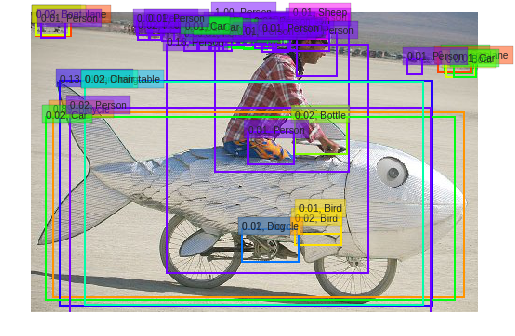

In [0]:
display_boxes(images[0],results[0],0)

**Exercise**: Try changing the value of nms_thresh to see how it changes the remaining predictions (before score thresholding).

At this point we filtered out high overlapping boxes, now let's pick the ones we want to display based on their detection confidence. Here we set a score threshold score_thresh of 0.6, and we only keep boxes with a higher score.

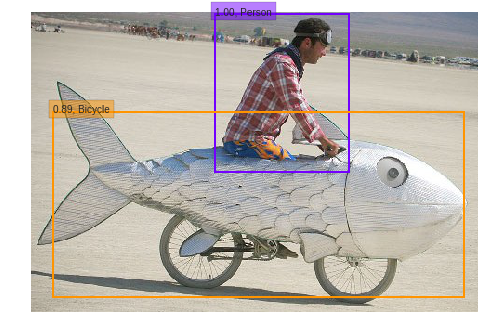

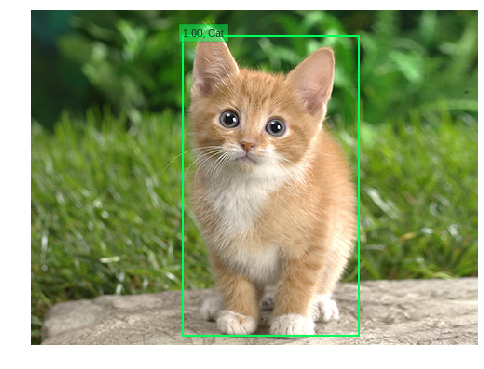

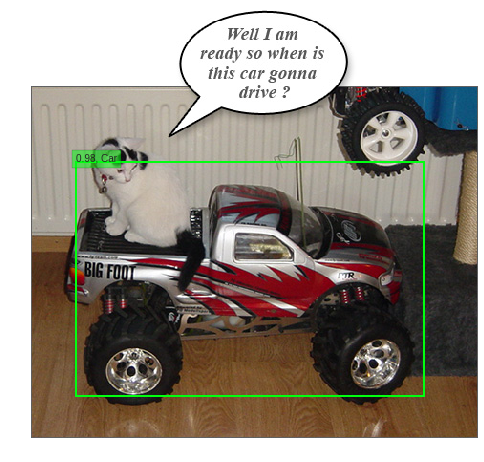

In [0]:
# min detection confidence to display
score_thresh = 0.6
for i, img in enumerate(images):
    display_boxes(img,results[i],score_thresh)

**Exercise**: Are these good results? We can see that the detector missed some objects. You can play with the different parameters that we fixed (e.g. nms_thresh, score_thresh) and see how they affect the results. You can also find more images in the same folder that you can test the network on.